# Identifying Transcription Factors through Genomics
By Laurence Liang

Transcription factors are essential to regulate gene and protein expression in cells. In the context of neuron regeneration, identifying TFs responsible for axon growth and understanding how the newtork of TFs work is an important step in promoting axon regeneration in the CNS.

![Alt Text](http://www.fridayfonts.com/wp-content/uploads/2009/05/neurons.jpg)

The goal of this project is to be able to identify TFs that regulate genes responsible for controlling axon regeneration in CNS. 

The method used is to develop a computer model that can accurately determine the composition of a transcription factor that regulates a target gene, based on the upstream sequence of the target gene. (Example, the gene A1 is a target gene controlled by transcription factor TF1. By analyzing the upstream of A1, the computer model should be able to determine the composition of TF1.)

![Alt Text](https://raw.githubusercontent.com/TheFloatingString/Neuron-Regeneration-Science-Fair-2019/master/images/Idea%20structure.jpg)

As the promoter can be difficult to determine in advance in eukaryotes, my code extracts a fixed number (2000) of base pairs before the starting index of a genes. The genetic sequence is then encoded in a numerical format that is compatible with the computer model. 

For the transcription factor, the signature we associate to each transcription factor is the frequency of amino acids, as the TF gene eventually produces a TF protein that will bind to a promoter sequence.

By using a Convolutional Neural Network, my goal is to train a computer model that can associate patterns in the genetic sequences of the upstream of a target gene to the amino acid frequency of its respective transcription factor.

Identifying TFs responsible for controlling axon regeneration genes can be attempted by using this model.

## Import modules

In [30]:
# Import BioPython used for computational biology
from Bio import Entrez
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio import SeqIO
Entrez.email = "laurencel2001@gmail.com"

# Import modules for data analysis
import pandas as pd
import numpy as np
import json
import time
import sys
import matplotlib.pyplot as plt
import random

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
scaler = MinMaxScaler()

# Keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras import optimizers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from keras import backend as K
K.set_image_dim_ordering('th')

## Functions used for processing data

For simplicity, a part of the preprocessing code as well as the databses necessary are omitted.

In [4]:
def numerize_amino_acid_coding(gene):
    """Outputs a 1D array of amino acid frequency based on input string of amino acid sequence"""
    list_of_amino_acids=['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'U', 'X']
    gene_vector = np.zeros(len(list_of_amino_acids))
    for amino_acid_char in gene:
        gene_vector[list_of_amino_acids.index(amino_acid_char)] += 1
    return gene_vector

In [6]:
def one_hot_dna(sequence):
    """Outputs a 2D array based on a one-hot encoding of a string of a DNA ATCG sequence"""
    try:
        return_list = []
        encoding_dict = {'A':0,
                     'T':1,
                     'C':2,
                     'G':3}
        for char in sequence:
            temp_array = np.zeros(4)
            temp_array[encoding_dict[char]] = 1
            return_list.append(temp_array)
        return return_list
    except KeyError:
        return '!'

In [10]:
def retrieve_promoter(chromosome_bank, chromosome_keys, chromosome_number, start_index, end_index, number_before=2000, number_after=500):
    """Function returns a sequence of the genome based on the index"""
    retrieve_start = start_index-number_before
    retrieve_end = start_index+number_after
    selected_sequence = str(chromosome_bank[chromosome_keys[chromosome_number]])[retrieve_start:retrieve_end]
    return selected_sequence

## Import data

Reading data of the "TF" ==> "Target gene" relationships

The data comes from the TRRUST database, a collection of documented TF relationships from PubMed articles

In [19]:
column_names = ["Transcription factor", "Target gene", "Relationship", "PubMED identifier"]
df = pd.read_csv("trrust_rawdata.human.tsv", delimiter='\t', header=None)
df.columns = column_names
df.head(5)

,Transcription factor,Target gene,Relationship,PubMED identifier
0,AATF,BAX,Repression,22909821
1,AATF,CDKN1A,Unknown,17157788
2,AATF,KLK3,Unknown,23146908
3,AATF,MYC,Activation,20549547
4,AATF,TP53,Unknown,17157788


Only retain relationships for activation

In [20]:
df_activation = df.loc[df['Relationship'] == "Activation"]
df_activation.shape

(3149, 4)

Reading data of the various positions of genes

In [7]:
column_names = ["Gene name", "Chromosome", "Start", "End"]
df_locations = pd.read_csv("gene_locations.csv", delimiter=',', header=None)
df_locations.columns = column_names
df_locations.sample(10)

,Gene name,Chromosome,Start,End
2609,TJP1,15.0,29699367.0,29968865.0
1468,LGALS4,19.0,38801671.0,38813364.0
1273,IGFBP5,2.0,216672105.0,216695525.0
160,ASF1B,19.0,14119509.0,14136956.0
1724,NCOA3,20.0,47501902.0,47656877.0
1677,MUC1,1.0,155185824.0,155192916.0
965,GAD1,2.0,170813213.0,170861151.0
591,CYP11B1,8.0,142872356.0,142879846.0
1802,NPAT,!,!,!
1260,IFNL1,!,!,!


Reading data from the human genome in FASTA file format

In [16]:
dict_of_sequences = {}
for seq_record in SeqIO.parse("datasets/genomic.fna", "fasta"):
    print(seq_record.id)
    dict_of_sequences[seq_record.id] = seq_record.seq


In [9]:
for key in list(dict_of_sequences.keys()):
    if key[0:2] != "NC":
        dict_of_sequences.pop(key, None)

In [13]:
chromosome_keys = dict(enumerate(list(dict_of_sequences.keys())))

In [14]:
promoter_sequences = {}
for index, row in df_locations.iterrows():
    if row["Chromosome"] != '!' and row["Start"] != "!" and row["End"] != '!':
        sequence = retrieve_promoter(dict_of_sequences, chromosome_keys, int(float(row["Chromosome"]))-1, int(float(row["Start"]))-1000, int(float(row["End"]))+1000)
        promoter_sequences[row["Gene name"]] = sequence

In [15]:
promoter_sequences_one_hot = {}
for gene_name in list(promoter_sequences.keys()):
    promoter_sequences_one_hot[gene_name] = one_hot_dna(promoter_sequences[gene_name].upper())

Load data for amino acids

In [5]:
amino_acid_bank = np.loadtxt("amino_acid_db.csv", delimiter="|", dtype=object)
amino_acid_dict = {}
for row in amino_acid_bank:
    amino_acid_dict[row[0]] = row[1].split(']')[-1].replace("\n", '')

In [17]:
promoter_sequences_one_hot = {k: v for k, v in promoter_sequences_one_hot.items() if v != '!'}
len(promoter_sequences_one_hot.keys())

2197

## Process data for model

Convert all lists to NumPy format

In [253]:
X_data = [] # Target gene
y_data = [] # TF

for index, row in df_activation.iterrows():
    print(row['Target gene'])
    try:
        if promoter_sequences_one_hot[row['Target gene']] != '!' and amino_acid_dict[row["Transcription factor"]] != '!':
            
            X_data.append(np.array(promoter_sequences_one_hot[row['Target gene']])) 
            y_data.append(numerize_amino_acid_coding(amino_acid_dict[row["Transcription factor"]]))
    except KeyError:
        pass

In [57]:
X_data = np.array(X_data)
print(X_data.shape)

y_data = np.array(y_data)
print(y_data.shape)


(2451, 2500, 4)
(2451, 22)


Scale data

In [58]:
new_y_data = []
for row in y_data:
    temp = []
    for item in row:
        temp.append(item/100)
    new_y_data.append(temp)

Split data for training and testing, and reshape data to fit the model

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_data, new_y_data, test_size=0.1)
X_train = np.array(X_train).reshape(len(X_train),1,2500,4)
X_test = np.array(X_test).reshape(len(X_test),1,2500,4)

## Demonstration of the model

![Alt Text](https://cdn-images-1.medium.com/max/1600/1*NQQiyYqJJj4PSYAeWvxutg.png)

Essentially, the Convolutional Neural Network tries to make mathematical links between features that appear at the input and the values for the output. The training was done in another program, there were 2094 training samples and 111 validation samples. The best validation loss (mean absolute error) was 0.1246.

Load Convolutional Neural Network

In [29]:
model = Sequential()
model = load_model("weights-improvement-25-0.13.hdf5")

Structure of the Convolutional Neural Network

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 10, 2451, 1)       2010      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 10, 245, 1)        0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 2450)              0         
_________________________________________________________________
dense_153 (Dense)            (None, 50)                122550    
_________________________________________________________________
dense_154 (Dense)            (None, 20)                1020      
_________________________________________________________________
dense_155 (Dense)            (None, 22)                462       
Total params: 126,042
Trainable params: 126,042
Non-trainable params: 0
_________________________________________________________________


In [46]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [99]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

## Visualization of the filters that the Convolutional Neural Network uses to detect features within the gene sequence

![Alt Text](https://cdn-images-1.medium.com/max/1200/1*ZCjPUFrB6eHPRi4eyP6aaA.gif)

The convolutional neural network is able to recognize features by sliding a filter across the gene sequence in a process known as convolution. The filter itself is learned continuously during the training of the neural network.

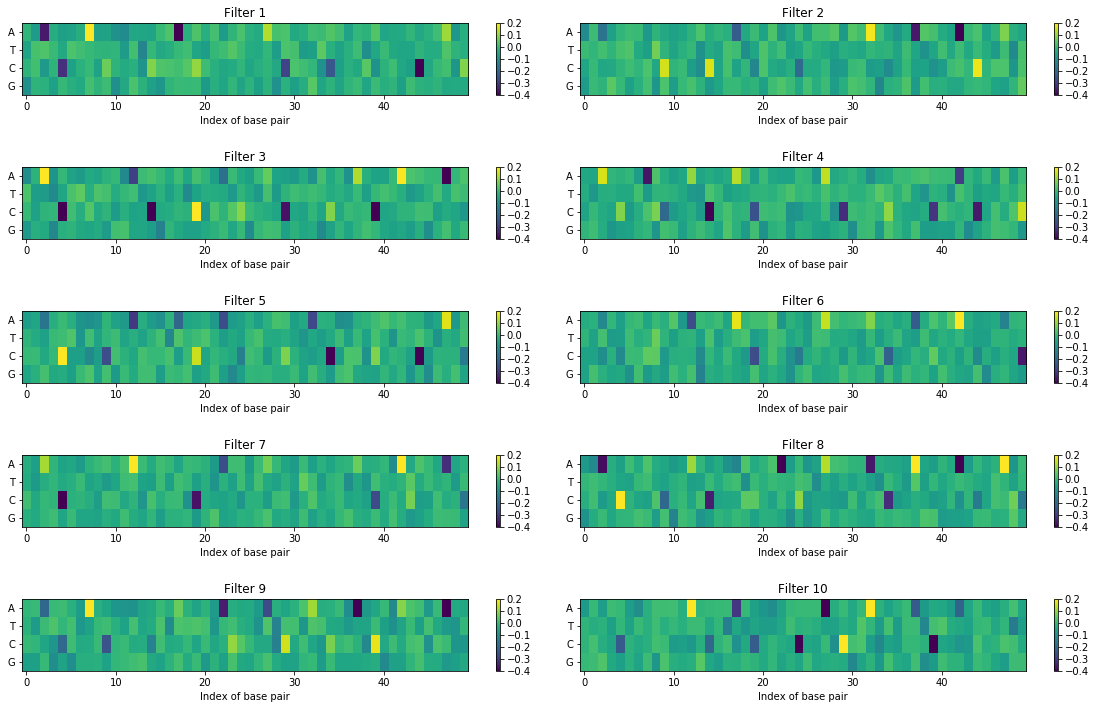

In [252]:
%matplotlib inline

width = 20
height = 1
plt.figure(figsize=(width, height))

bp_list = ['A', 'T', 'C', 'G']
for row in range(10):
    plt.subplot(5,2,row+1)
    plt.title(f"Filter {row+1}")
    
    plt.yticks(range(4), bp_list)
    plt.xlabel("Index of base pair")

    plt.imshow(weights[0][0].reshape(10,50,4)[row].T, cmap="viridis", aspect='auto', vmin=-0.4, vmax=0.2)
    plt.colorbar()

plt.subplots_adjust(left=None, bottom=0, right=None, top=9, wspace=0, hspace=1)
plt.show()

We can observe that the filters tend to have a high sensitivity towards certain base pairs with A and C. Also, there seems to be an alternating movement between A and C base pairs, which could be somehow revealing when searching for the amino acid composition of a transcription factor based on the genetic sequence of the upstream of a gene.

## Analysis of the accuracy of the model

Compute baseline error. The number (multiplied by 100) is the number of amino acid counts that the prediction was off (per type of AA).

The baseline model takes the average occurence for each amino acid, then compares the average frequency with the real values.

In [35]:
answer_list = []
y_test = np.array(y_test)
for feature in range(len(y_test[0])):
    answer_list.append((sum(y_test[:,feature])/len(y_test)))
        
total_error = 0.0
for pr, value in zip(pred_positive, y_test):
    temp_sum = 0.0
    for p, v in zip(answer_list, value):
        temp_sum += abs(p-v)
    total_error += temp_sum
error = total_error/len(pred_positive)
print("Total error with baseline model",error)

Total error with baseline model 3.2441823649943826


In [34]:
pred = model.predict([X_test])
pred_positive = [[0.0 if val<= 0.0 else val for val in subl] for subl in pred ]
pred_positive = [[val for val in subl] for subl in pred ]


var=random.randrange(0,len(X_test))
print(f"Random sample: {var}")

print(f"Real \t Prediction")
for real, prediction in zip(y_test[var], pred_positive[var]): 
    print(f"{real}\t{round(prediction,2)}")

print()
print("Average value of amino acid", np.array(pred_positive).mean())
print("Stadard deviation per amino acid", np.array(pred_positive).std())

total_error = 0.0
for pr, value in zip(pred_positive, y_test):
    temp_sum = 0.0
    for p, v in zip(pr, value):
        temp_sum += abs(p-v)
    total_error += temp_sum
error = total_error/len(pred_positive)
print("Average error per gene", error)

Random sample: 158
Real 	 Prediction
0.37	0.3400000035762787
0.16	0.23000000417232513
0.12	0.14000000059604645
0.12	0.20999999344348907
0.04	0.07999999821186066
0.37	0.23000000417232513
0.24	0.25
0.16	0.28999999165534973
0.03	0.10999999940395355
0.18	0.15000000596046448
0.21	0.38999998569488525
0.15	0.20000000298023224
0.07	0.10999999940395355
0.01	0.12999999523162842
0.19	0.3799999952316284
0.3	0.4099999964237213
0.34	0.23999999463558197
0.0	0.029999999329447746
0.07	0.10000000149011612
0.28	0.2199999988079071
0.0	0.0
0.0	0.0

Average value of amino acid 0.20430316
Stadard deviation per amino acid 0.13543938
Average error per gene 2.849071214474978


(3.24-2.84)/2.84 = 14%. Our computer model is 14% more accurate than the baseline model

### Visualization of the predicted results versus the real results

On the x-axis, we have vertical strips of the predicted amino acid frequency of each TF gene's amino acid composition. On the y-axis, we have the types of amino acids. Do note that the predictions seem to vary per case, meaning that the model doesn't blindly output a single generic answer to any input.

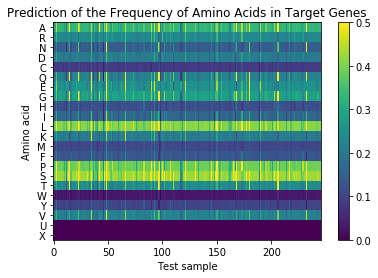

In [43]:
list_of_amino_acids=['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'U', 'X']

plt.imshow(np.array(pred_positive).T, aspect='auto')
plt.colorbar()
plt.clim(0,0.5)

plt.title("Prediction of the Frequency of Amino Acids in Target Genes")

plt.xlabel("Test sample")

plt.yticks(range(22), list_of_amino_acids)
plt.ylabel("Amino acid")

plt.show()

Real results.

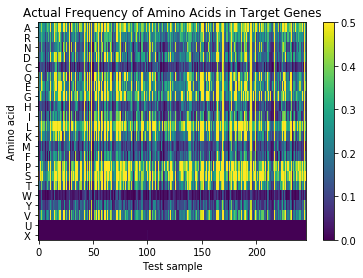

In [45]:
plt.imshow(np.array(y_test).T, aspect='auto')
plt.colorbar()
plt.clim(0,0.5)

plt.title("Actual Frequency of Amino Acids in Target Genes")

plt.xlabel("Test sample")

plt.yticks(range(22), list_of_amino_acids)
plt.ylabel("Amino acid")

plt.show()

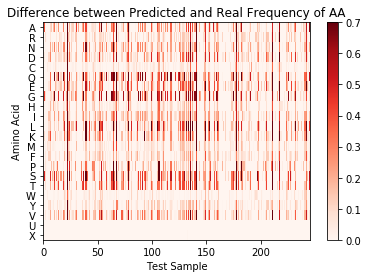

In [189]:
plt.imshow(np.subtract(np.array(y_test).T, np.array(pred_positive).T), aspect='auto', interpolation="nearest", cmap='Reds')
plt.colorbar()
plt.clim(0,0.7)

plt.title("Difference between Predicted and Real Frequency of AA")

plt.yticks(range(22), list_of_amino_acids)
plt.xlabel("Test Sample")
plt.ylabel("Amino Acid")

plt.show()

#